In [5]:
cd '/Users/jbud/Desktop/Galvanize/repos/World_Renew_Energy'

/Users/jbud/Desktop/Galvanize/repos/World_Renew_Energy


Cell below imports script from VS Code in order to create plots

In [7]:
# %load 'src/main.py'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.close('all')

#Year parameters - must be between 1980 and 2017 (inclusive)
start_year = 1980
end_year = 2017
years_analyzed = range(start_year, end_year + 1)

countries_to_analyze = 35

#The analysis class will allow a user to, after defining, add a list of countries. These will then be converted into proportions and can be plotted and/or used for a hypothesis test of whether the proportions have increased over the years.

class Analysis(object):
    def __init__(self, data, title = 'untitled', startcol = 1980):
        self.data = data.drop(range(1980, startcol), axis = 1)
        self.year = data.columns[(startcol-1978):]
        self.title = title
        self.analyze_list = []
        self.countries_analyzed = []

    def show_countries(self, for_analysis = 'T'):
        return self.countries_analyzed if for_analysis == 'T' else set(self.data.loc[:,'Country'])

    #Check that the aggregated rows equal the sum of the subset rows
    def check_aggregates(self, country = 'Norway', start_year= 1980, end_year = 2017):
        print('Checking Renewable subrows = renewable total row')
        for each in range(start_year, end_year + 1):
            if round(energy_data[energy_data['Country'] == country].loc[:,each].iloc[4:10].sum(),3) != round(energy_data[energy_data['Country'] == country].loc[:, each].iloc[3], 3):
                print(each,' has unequal values')
                break
        print('Checked Renewable subrows = renewable total row')
        print('Checking all subrows =  total row')
        for each in range(start_year, end_year + 1):
            if round(energy_data[energy_data['Country'] == country].loc[:, each].iloc[[1, 2, 3, 10]].sum(), 3) != round(energy_data[energy_data['Country'] == country].loc[:, each].iloc[0], 3):
                print(each,' has unequal values')
                break
        print('Checked all subrows=total row')

    def add_countries(self, country_list, orderby_latest=True):
        self.propDF = calculate_proportions(country_list, orderby_latest=True)
        if orderby_latest == True:
            self.propDF.sort_values(self.year[-1], ascending = False, inplace = True)
        self.analyze_list = self.propDF.to_numpy()
        self.countries_analyzed = list(self.propDF.index)
        return self.propDF

    def plot_data(self, figsize = (14, 8), maxlines= 10, include_world = False, include_legend = True):
        self.fig, ax = plt.subplots(1, 1, figsize= figsize)
        if include_world == True:
            ax.plot(self.year, calculate_proportions(["World"]).to_numpy().flatten()[(self.year[0]- 1980):], color = 'blue', ls=(0, (10, 12)), linewidth=0.8, label='World')
        for i, y_data_set in enumerate(self.analyze_list[0: maxlines]):
            ax.plot(self.year, y_data_set[(self.year[0] - 1980):], label = self.countries_analyzed[i])
        ax.set_ylabel('Proportion of Total Electrcity Generated')
        ax.set_title('Renewable Electricity Produced from {}'.format(self.title))
        ax.legend(loc ='center left', bbox_to_anchor = (1, 0.5)) if include_legend == True else None
        return self.fig

    def make_hist(self, figsize = (12,8)):
        self.fig, ax = plt.subplots(1,1, figsize = figsize)
        ax.hist([self.propDF[self.year[0]], self.propDF[self.year[20]], self.propDF[self.year[-1]]], label = [self.year[0], self.year[20], self.year[-1]])
        ax.legend()
        ax.set_xlabel('Proportion of Renewable Electricity Produced')
        ax.set_title('Histogram of {}'.format(self.title))
        return self.fig

    def hypo_test(self, aggregated = True, increase_thres = 0.15, alpha = 0.05):
        #Use average of 1980 to 1983 and 2014 to 2017 to account for variability
        n = len(self.countries_analyzed)
        subset1_avgs = []
        subset2_avgs = []

        for prop in self.analyze_list:
            country_subset1 = np.mean([prop[(yr1 - 1980)] for yr1 in self.year[0:3]])
            subset1_avgs.append(country_subset1)
            country_subset2 = np.mean([prop[list(self.year).index(yr2)] for yr2 in self.year[-3:]])
            subset2_avgs.append(country_subset2)
        if aggregated == True:
            subset1_mean, subset1_stdev = np.mean(subset1_avgs), np.std(subset1_avgs)
            subset2_mean= np.mean(subset2_avgs)
            p = 1 - stats.norm(subset1_mean, subset1_stdev).cdf(subset2_mean)
            print('P-value: ', p)
            if p <= alpha:
                print("Reject null hypothesis. Evidence suggests that {} are generating a greater proportion of renewable electricity in {} than in {}".format(self.title, self.year[-1], self.year[0]))
            else:
                print("Fail to reject null hypothesis. Insufficient evidence to suggest that {} are generating a greater proportion of electricity in {} than in {}.". format(self.title, self.year[-1], self.year[0]))
        else:
            counter = 0
            total = 0
            for i in range(n):
                if (subset2_avgs[i] >= 0.9) & (subset1_avgs[i] >= 0.9):
                    continue
                if subset2_avgs[i] >= subset1_avgs[i] + increase_thres:
                    counter += 1
                    total += 1
                elif subset2_avgs[i] <= subset1_avgs[i]:
                    total += 1
            p = 1 - stats.binom(total, p=0.5).cdf(counter)
            print('P-value: ', p)
            if p <= alpha:
                print("Reject null hypothesis. Evidence suggests that more than 50% of countries have increased renewable electricity proportion by at least {} % in the time period.".format(100 *increase_thres))
            else:
                print("Fail to reject null hypothesis. Insufficient evidence to suggest that more than 50% of countries have increased renewable electricity generation by at least {} % in the time period".format(100*increase_thres))

def indent_replace(a_series):
    new_series = []
    for string in a_series:
        no_indent = string.lstrip()
        space_count = len(string) - len(no_indent)
        if space_count == 4:
            type1, type2 = 0, 0
            new_series.append(no_indent)
        elif space_count == 8:
            type1 += 1
            new_series.append('{}'.format(type1) + '.' + no_indent)
        elif space_count >= 12:
            type2 += 1
            new_series.append('{}'.format(type1) + '.' + '{}'.format(type2) + '.' + no_indent)
        else:
            print('error, ommitted {}'.format(string))
    return new_series

def combine_countries(df, combine_list, into_country):
    into_data = df[df['Country'] == into_country].loc[:, years_analyzed]
    into_rows = into_data.index
    into_country_data = into_data.to_numpy()
    for country in combine_list:
        into_country_data += df[df['Country'] == country].loc[:, years_analyzed].to_numpy()
        row_indexes = df[df['Country'] == country].loc[:, years_analyzed].index
        df.loc[row_indexes, years_analyzed] = 0
    df.loc[into_rows, years_analyzed] = into_country_data
    return df

    #For now only calculates proportion of renewable electricity sources over total - could be modified to include more
    #Countries with a total electricity generation of 0 on end year are assumed to be missing data and are dropped.

def calculate_proportions(country_list, orderby_latest = True):
    calc_list, countries_calc = [], []
    for country in country_list:
        if country not in set(energy_data['Country']):
            print(country, 'is not in energy data and has been skipped.')
            continue
        if float(energy_data[end_year][(energy_data['Country'] == country) & (energy_data['Energy Type'] == 'Generation (billion Kwh)')]) == 0:
            #print(country, 'has 0 or unknown electricity generation. Skipped')
            continue

        renewable_vals = energy_data[(energy_data['Country'] == country) & (energy_data['Energy Type'] == '3.Renewables (billion Kwh)')]

        total_gen = energy_data[(energy_data['Country'] == country) & (
            energy_data['Energy Type'] == 'Generation (billion Kwh)')].iloc[0, 2:].to_numpy()

        hydro_storage = energy_data[(energy_data['Country'] == country) & (
            energy_data['Energy Type'] == '4.Hydroelectric pumped storage (billion Kwh)')].iloc[0,2:].to_numpy()

        total_generation_vals = total_gen - hydro_storage
        renewable_vals = renewable_vals.iloc[:, 2:].to_numpy().flatten()
        if 0 in total_generation_vals:
            renew_proportions = []
            for i, each in enumerate(total_generation_vals):
                if each != 0:
                    renew_proportions.append(renewable_vals[i]/ total_generation_vals[i])
                else:
                    renew_proportions.append(each)
        else:
            renew_proportions = renewable_vals / total_generation_vals
        renew_proportions = np.array([round(each, 3) for each in renew_proportions])
        calc_list.append(renew_proportions)
        countries_calc.append(country)
        RenewDF = pd.DataFrame(calc_list, columns = years_analyzed, index = countries_calc)
        if orderby_latest == True:
            RenewDF.sort_values(years_analyzed[-1], ascending = False)
    return RenewDF

def get_improved_countries(countries, improvement_perc=.274, years=years_analyzed, include_early_0s=False):
    propDF = calculate_proportions(countries)
    propDF['Improvement'] = propDF[years[-1]] - propDF[years[0]]
    propDF = propDF[propDF['Improvement'] >= improvement_perc]
    if include_early_0s == False:
        propDF = propDF[propDF[years[0]] != 0]
    propDF.sort_values('Improvement', ascending = False, inplace = True)
    return propDF

def years_to_int(first_year=start_year, last_year=end_year):
    years_to_int = {str(year): year for year in range(
        first_year, last_year + 1)}
    return years_to_int

plt.style.use('ggplot')


if __name__ == '__main__':
    '''
    -----------------------------------------------------------------
    Import electricity generation data and clean it
    -----------------------------------------------------------------
    The original energy data is formatted with leading spaces to identify subgroups of each type. This function iterates through and replaces these using numerical indexing for readbility in DataFrames.
    Assumptions - "--" or NaN means that no data is available for the time period. These will be replaced with 0. 
    '''

    energy_data = pd.read_csv('data/INT-Export-04-05-2020_00-10-38.csv', header=1)
    energy_data.rename(columns={'Unnamed: 1': 'Energy Type', 'API': 'Country Code'}, inplace = True)
    energy_data.rename(columns = years_to_int(), inplace=True)
    # 2018 has a lot of missing data
    energy_data.drop('2018', axis=1, inplace=True)

    #Original dataset has several rows that are totals of other forms of energy. This section drops the rows of totals so that only renewable energy has subgroups. Several countries are missing a country code and these are specified manually.
    energy_data['Country Code'].loc[1981:1994] = 'Micronesia'
    energy_data['Country Code'].loc[2297:2309] = 'MNP'
    energy_data['Country Code'].loc[3181:3194] = 'Tuvalu'
    energy_data['Country Code'].loc[3211:3224] = 'U.S. Territories'
    countries = energy_data['Energy Type'][0::15]
    energy_data.drop(energy_data.loc[0::15].index, inplace=True)
    energy_data.drop(energy_data.loc[6::14].index, inplace=True)
    energy_data.drop(energy_data.loc[8::13].index, inplace=True)
    energy_data.drop(energy_data.loc[9::12].index, inplace=True)
    energy_data.reset_index(drop = True, inplace = True)

    energy_data.drop(
        energy_data[energy_data['Country Code'] == 'none'].index, inplace=True)

    country_code = []
    for code in energy_data['Country Code']:
        if code != 'none' and type(code) == str and code.count('-') >= 3:
            country_code.append(code.split('-')[2])
        else:
            country_code.append(code)

    energy_data['Country Code'] = country_code
    energy_data['Country Code'][energy_data['Country Code'] == 'WORL'] = 'WLD'
    energy_data['Energy Type'] = indent_replace(energy_data['Energy Type'])
    energy_data.fillna(0, inplace=True)
    energy_data.replace('--', 0, inplace = True)
    energy_data.iloc[:, 2:] = energy_data.iloc[:, 2:].astype('float')

    #Countries provides another dataframe to translate country codes into Country Names
    countries.reset_index(drop=True, inplace=True)
    country_code = energy_data['Country Code'].copy()
    country_code.drop_duplicates(inplace=True)
    country_code.reset_index(drop = True, inplace = True)
    countries = pd.DataFrame(country_code).join(countries)
    countries.rename(columns ={'Energy Type': 'Country'}, inplace = True)
    energy_data.merge(countries)

    #Replace Country codes with country names, combines split countries
    energy_data = energy_data.iloc[:, :1].merge(countries).join(energy_data.iloc[:, 1:])
    energy_data.drop('Country Code', axis=1, inplace = True)
    combine_countries(energy_data, ['Germany, East', 'Germany, West'], 'Germany')
    combine_countries(energy_data, ['Former Czechoslovakia'], 'Czech Republic')
    combine_countries(energy_data, ['Former U.S.S.R.'], 'Russia')

    allcountries = set(energy_data['Country'][1:])
    allcountries.remove("World")

    '''
    -----------------------------------------------------------------
    Import UN HDI data and clean
    -----------------------------------------------------------------
    '''
    HDI_data = pd.read_csv('data/HDI.csv', nrows=190)
    HDI_data.rename(columns=years_to_int(1990, 2018), inplace=True)
    HDI_data.drop(0, inplace = True)
    HDI_data['Country'] = HDI_data['Country'].str.lstrip()
    HDI_data.drop([HDI_data.columns[x] for x in range(
        3, len(HDI_data.columns), 2)], axis=1, inplace=True)
    HDI_data.iloc[:, 0] = HDI_data.iloc[:, 0].astype('int')
    HDI_data['Country'].replace(
        'Hong Kong, China (SAR)', "Hong Kong", inplace=True)
    HDI_data['Country'].replace(
        'Korea (Republic of)', "South Korea", inplace=True)
    HDI_data['Country'].replace(
        'Czechia', "Czech Republic", inplace=True)
    HDI_data['Country'].replace(
        'Russian Federation', "Russia", inplace=True)
    HDI_data['Country'].replace(
        'Congo (Democratic Republic of the)', "Congo-Kinshasa", inplace=True)
    HDI_data['Country'].replace(
        'Gambia', "Gambia, The", inplace=True)
    HDI_data['Country'].replace(
        "Côte d'Ivoire", "Cote dIvoire", inplace=True)
    HDI_data['Country'].replace(
        'Tanzania (United Republic of)', "Tanzania", inplace=True)
    developed_data = HDI_data.sort_values('HDI Rank')['Country'].reset_index(drop = True)
    developed_countries = list(developed_data)
    '''
    -----------------------------------------------------------------
    Import population data and clean it
    -----------------------------------------------------------------
    '''

    pop_data = pd.read_csv('data/API_SP.POP.csv', header=4)
    pop_data_min_year = 1960
    pop_data.rename(columns=years_to_int(pop_data_min_year), inplace=True)

    pop_data.drop(['Unnamed: 64', 'Indicator Name',
                        'Indicator Code', '2018', '2019'], axis=1, inplace=True)

    #Removing aggregated regions to avoid double counting
    regions_to_remove = (
        'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'East Asia & Pacific (IDA & IBRD countries)','Europe & Central Asia (IDA & IBRD countries)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IBRD only', 'IDA & IBRD total', 'IDA total', 'IDA blend', 'IDA only', 'Latin America & Caribbean', 'Latin America & the Caribbean (IDA & IBRD countries)', 'IDA only', 'Late-demographic dividend', 'Latin America & Caribbean (excluding high income)',
        'Least developed countries: UN classification', 'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle East & North Africa (IDA & IBRD countries)', 'North America', 'Not classified', 'OECD members', 'Other small states', 'Pacific island small states', 'Pre-demographic dividend', 'Post-demographic dividend', 'Small states', 'South Asia', 'South Asia (IDA & IBRD)','Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)', 'High income', 'Low & middle income', 'Low income', 'Lower middle income', 'Middle income', 'Upper middle income')

    pop_data.drop(pop_data[pop_data['Country Name'].isin(regions_to_remove)].index, inplace=True)

    #Modifying index so that aggregated World row is placed on top, rest are alphabetical order, removing invalid entries

    pop_data.sort_values('Country Name', inplace=True)
    pop_data.fillna(0, inplace=True)
    pop_data.reset_index(drop = True, inplace = True)
    pop_data.index += 1
    pop_data.loc[0] = pop_data.loc[215]
    pop_data.drop(215, inplace = True)
    pop_data.sort_index(inplace=True)
    pop_data.reset_index(drop=True, inplace=True)
    pop_data.rename(columns = {'Country Name' : 'Country'}, inplace = True)
    pop_data['Country'].replace(
        'Russian Federation', "Russia", inplace=True)
    pop_data['Country'].replace(
        'Egypt, Arab Rep.', "Egypt", inplace=True)
    pop_data['Country'].replace(
        'Iran, Islamic Rep.', "Iran", inplace=True)
    pop_data['Country'].replace(
        'Korea, Rep.', "South Korea", inplace=True)
    pop_data['Country'].replace(
        'Congo, Dem. Rep.', "Congo-Kinshasa", inplace=True)
    '''
    --------------------------------------------
    Highest population dataset determined here
    --------------------------------------------
    '''
    high_pop = pop_data.sort_values(start_year,ascending = False).copy()[1: countries_to_analyze]

    '''
    -------------------------------------------
    Continent Data
    -------------------------------------------
    '''
    cont_data = pd.read_csv('data/CountryContent.csv', header = 4)
    cont_data.drop(['4203.93645368'],
                axis=1, inplace=True)
    cont_data.rename(columns={
                    'INTL.2-12-USA-BKWH.A': 'Continent', '        United States': 'Country'}, inplace=True)
    cont_data['Continent'].iloc[0:58] = 'Africa'
    cont_data['Continent'].iloc[58:106] = 'Asia & Oceania'
    cont_data['Continent'].iloc[106:152] = 'Central & South America'
    cont_data['Continent'].iloc[152:160] = 'North America'
    cont_data['Continent'].iloc[160:175] = 'Middle East'
    cont_data['Continent'].iloc[175:221] = 'Europe'
    cont_data['Continent'].iloc[221:] = 'Eurasia'
    cont_data['Country'] = cont_data['Country'].str.lstrip()
    cont_data.drop([0, 58, 106, 152, 160, 175, 221], inplace = True)
    cont_data.reset_index(drop = True)

    cont_data['Country'].replace("Côte d’Ivoire", "Cote dIvoire", inplace=True)

    #Plots found in notebooks/Capstone1Plots.ipynb


    Worldwide_Analysis = Analysis(energy_data, title='Worldwide')
    Development_Analysis = Analysis(energy_data, title='Top Developed Countries')
    Development_Analysis.add_countries(developed_countries[:countries_to_analyze], orderby_latest = False)
    Development_Analysis.hypo_test()
    Development_Analysis.hypo_test(aggregated = False)    

    print('------------------------------------------')

    Least_Dev_Analysis = Analysis(energy_data, title = 'Least Developed Countries')
    Least_Dev_Analysis.add_countries(
        developed_countries[-1: -1 * countries_to_analyze: -1], orderby_latest = False)
    Least_Dev_Analysis.hypo_test()

    print('------------------------------------------')

    HighPop_Analysis = Analysis(energy_data, 'Countries with Largest Population')
    HighPop_Analysis.add_countries(list(high_pop['Country']), orderby_latest= False)
    HighPop_Analysis.hypo_test()

    print('------------------------------------------')

    North_America_Analysis = Analysis(energy_data, 'North American Countries')
    North_America_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'North America'].loc[:, 'Country'])
    North_America_Analysis.hypo_test()

    print('------------------------------------------')

    South_America_Analysis = Analysis(energy_data, 'Central & South American Countries')
    South_America_Analysis.add_countries(cont_data[cont_data['Continent'] == 'Central & South America'].loc[:, 'Country'])
    South_America_Analysis.hypo_test()

    print('------------------------------------------')

    Europe_Analysis = Analysis(energy_data, 'European Top Countries')
    Europe_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'Europe'].loc[:, 'Country'])
    Europe_Analysis.hypo_test()

    print('------------------------------------------')

#These countries split from USSR in 1992 - using that column instead of 1980
    Eurasia_Analysis = Analysis(energy_data, title ='Eurasia Top Countries', startcol = 1992)
    Eurasia_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'Eurasia'].loc[:, 'Country'])
    Eurasia_Analysis.hypo_test()

    print('------------------------------------------')

    Asia_Analysis = Analysis(
        energy_data, 'Asia & Oceania Countries')
    Asia_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'Asia & Oceania'].loc[:, 'Country'])
    Asia_Analysis.hypo_test()

    print('------------------------------------------')

    MidEast_Analysis = Analysis(
        energy_data, 'Middle East Countries')
    MidEast_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'Middle East'].loc[:, 'Country'])
    MidEast_Analysis.hypo_test()

    print('------------------------------------------')

    Africa_Analysis = Analysis(
        energy_data, 'African Countries')
    Africa_Analysis.add_countries(
        cont_data[cont_data['Continent'] == 'Africa'].loc[:, 'Country'])
    Africa_Analysis.hypo_test()

    print('------------------------------------------')

    Improved_Analysis = Analysis(energy_data, 'Largest Increase Countries')
    Improved_Analysis.add_countries(get_improved_countries(allcountries, improvement_perc=.27).index)
    Improved_Analysis.hypo_test()

    print('------------------------------------------')

    highest_prop_countries = list(calculate_proportions(allcountries).sort_values(
        2017, ascending=False).loc[:, 2017].iloc[:20].index)

    AllCountries_hist = Analysis(energy_data, 'All Countries in the World')
    AllCountries_hist.add_countries(allcountries)




Liechtenstein is not in energy data and has been skipped.
P-value:  0.3438849434785085
Fail to reject null hypothesis. Insufficient evidence to suggest that Top Developed Countries are generating a greater proportion of electricity in 2017 than in 1980.
P-value:  0.059234619140625
Fail to reject null hypothesis. Insufficient evidence to suggest that more than 50% of countries have increased renewable electricity generation by at least 15.0 % in the time period
------------------------------------------
P-value:  0.5092937590324915
Fail to reject null hypothesis. Insufficient evidence to suggest that Least Developed Countries are generating a greater proportion of electricity in 2017 than in 1980.
------------------------------------------
P-value:  0.530498573670834
Fail to reject null hypothesis. Insufficient evidence to suggest that Countries with Largest Population are generating a greater proportion of electricity in 2017 than in 1980.
------------------------------------------
P-v

In [8]:
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size':16})


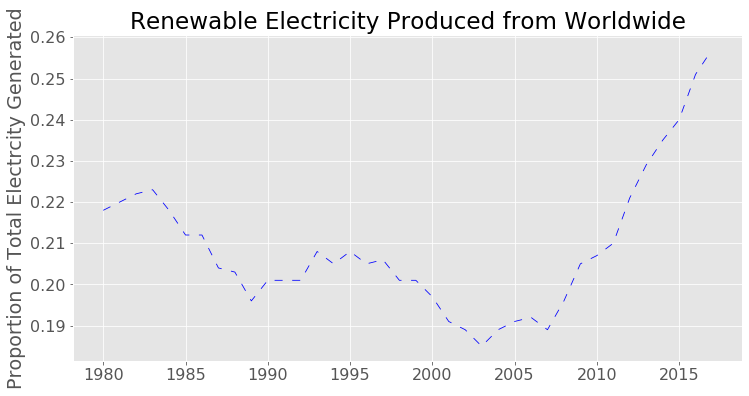

In [147]:
Worldwide_Analysis.plot_data(include_world = True, figsize = (12,6), include_legend = False)
plt.show()

In [127]:
Worldwide_Analysis.fig.savefig('images/World.png', bbox_inches='tight')

---

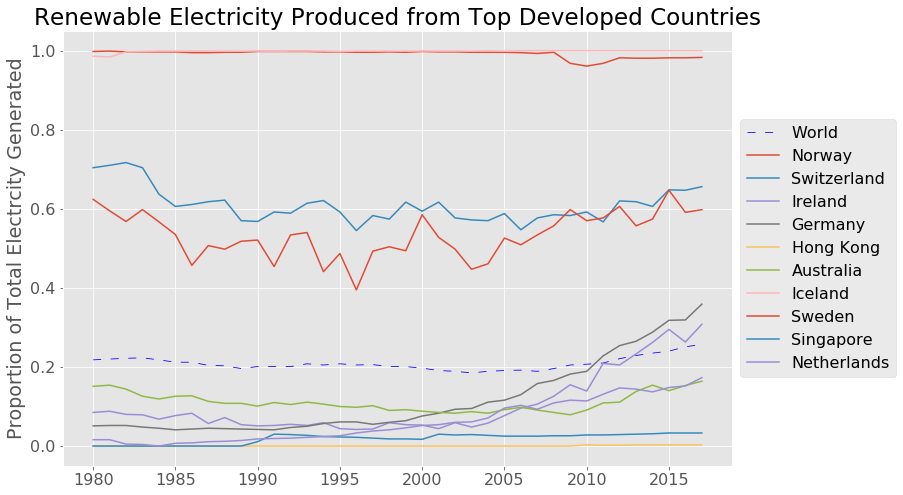

In [148]:
Development_Analysis.plot_data(maxlines = 10, figsize = (12,8), include_world = True)
plt.show()

In [ ]:
Development_Analysis.fig.savefig('images/Developed.png',  bbox_inches='tight')

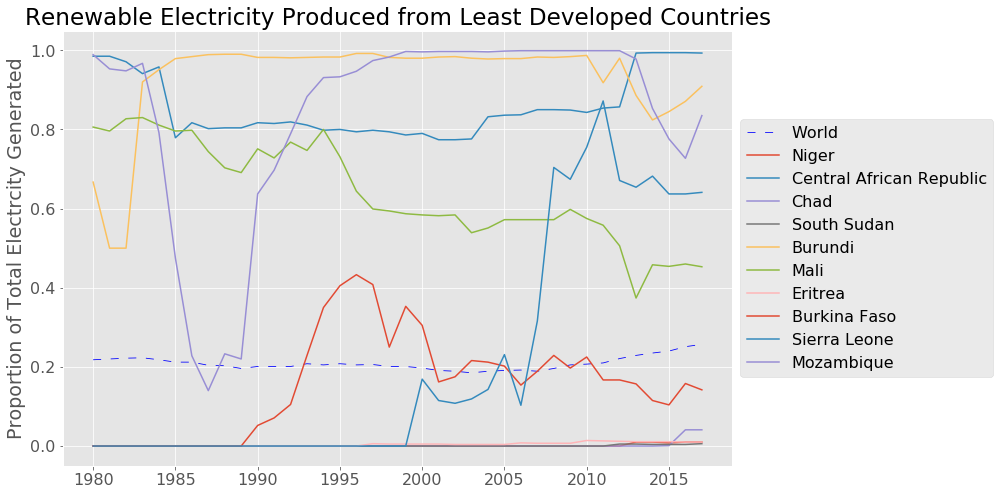

In [9]:
Least_Dev_Analysis.plot_data(maxlines = 10, figsize = (12, 8),include_world = True)
plt.show()

In [10]:
Least_Dev_Analysis.fig.savefig('images/lessDevelop.png', bbox_inches='tight')

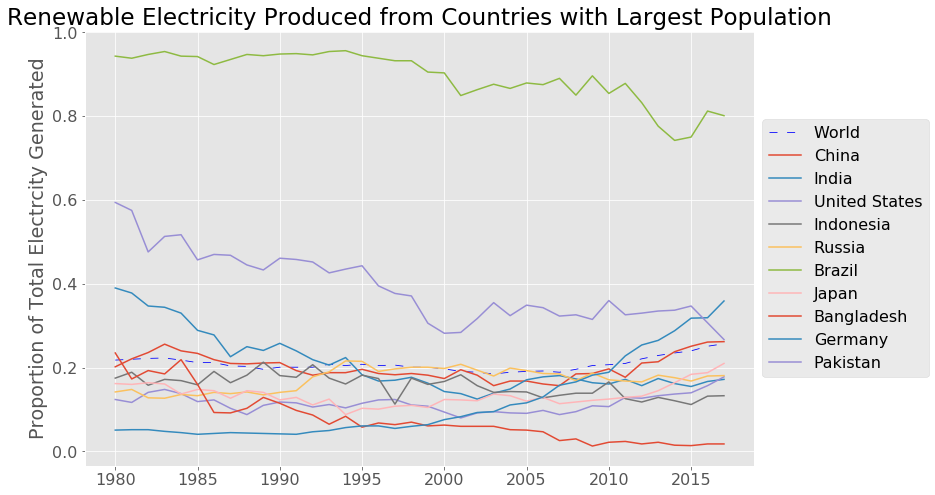

In [11]:
HighPop_Analysis.plot_data(maxlines = 10, figsize = (12, 8), include_world=True)
plt.show()

In [ ]:
HighPop_Analysis.fig.savefig('images/HighPop.png',  bbox_inches='tight')

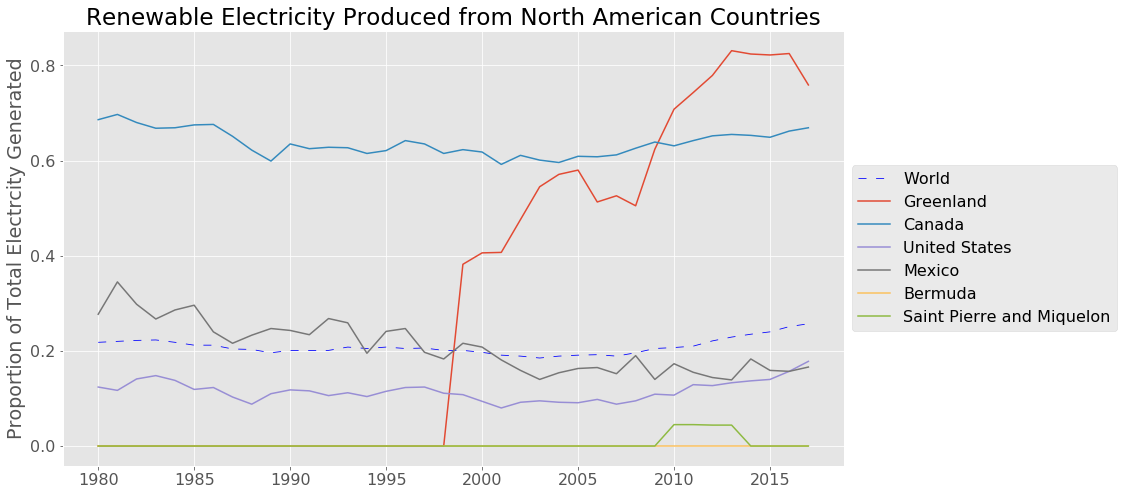

In [151]:
North_America_Analysis.plot_data(include_world=True)
plt.show()

In [152]:
North_America_Analysis.fig.savefig('images/NA.png',  bbox_inches='tight')

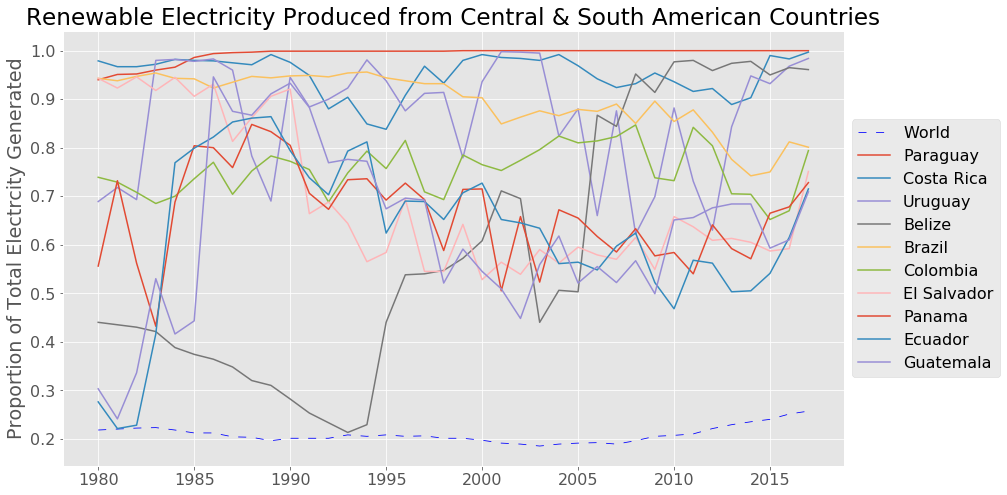

In [156]:
South_America_Analysis.plot_data(maxlines = 10, include_world=True)
plt.show()

In [157]:
South_America_Analysis.fig.savefig('images/SA.png',  bbox_inches='tight')

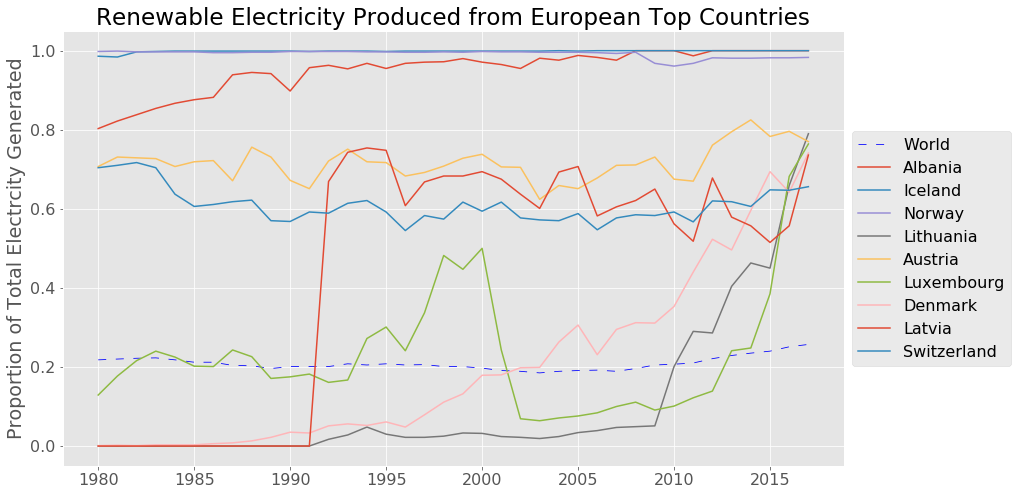

In [158]:
Europe_Analysis.plot_data(maxlines = 9, include_world=True)
plt.show()

In [159]:
Europe_Analysis.fig.savefig('images/EU.png',  bbox_inches='tight')

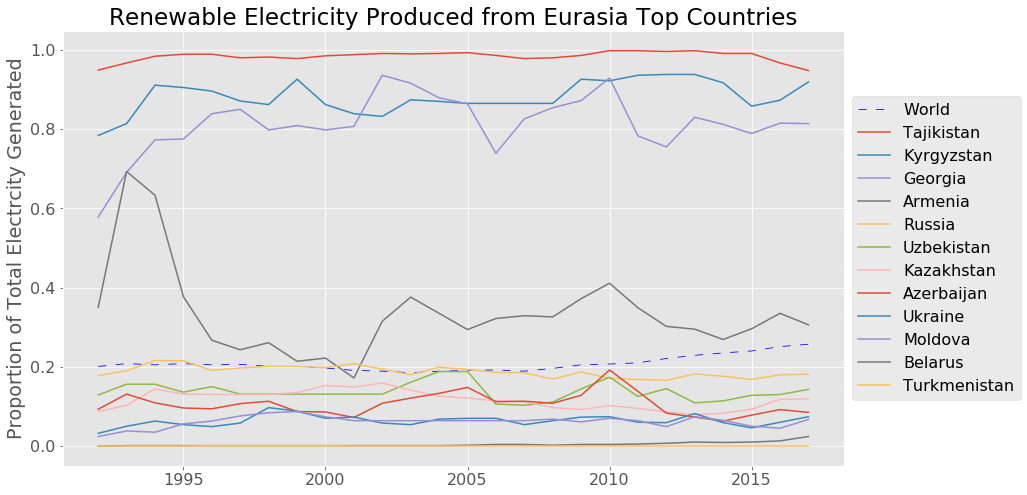

In [160]:
Eurasia_Analysis.plot_data(maxlines = 15, include_world = True)
plt.show()

In [161]:
Eurasia_Analysis.fig.savefig('images/EUasia.png',  bbox_inches='tight')

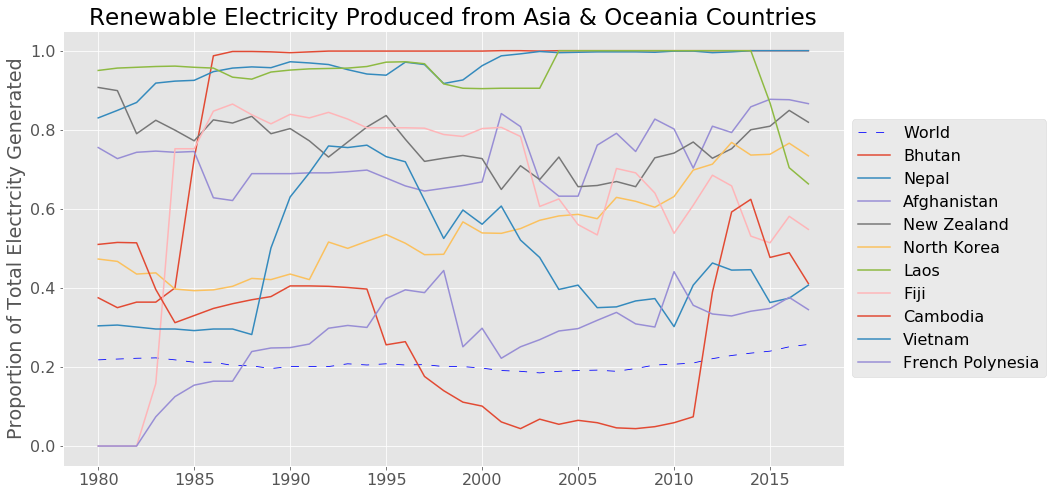

In [162]:
Asia_Analysis.plot_data(maxlines = 10, include_world=True)
plt.show()

In [163]:
Asia_Analysis.fig.savefig('images/asia.png',  bbox_inches='tight')

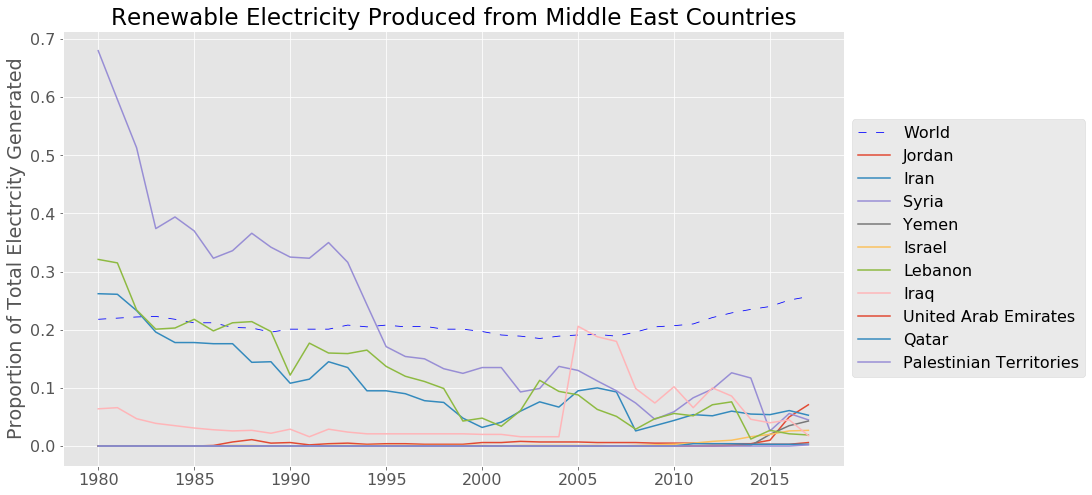

In [164]:
MidEast_Analysis.plot_data(maxlines = 10, include_world=True)
plt.show()

In [165]:
MidEast_Analysis.fig.savefig('images/MidE.png',  bbox_inches='tight')

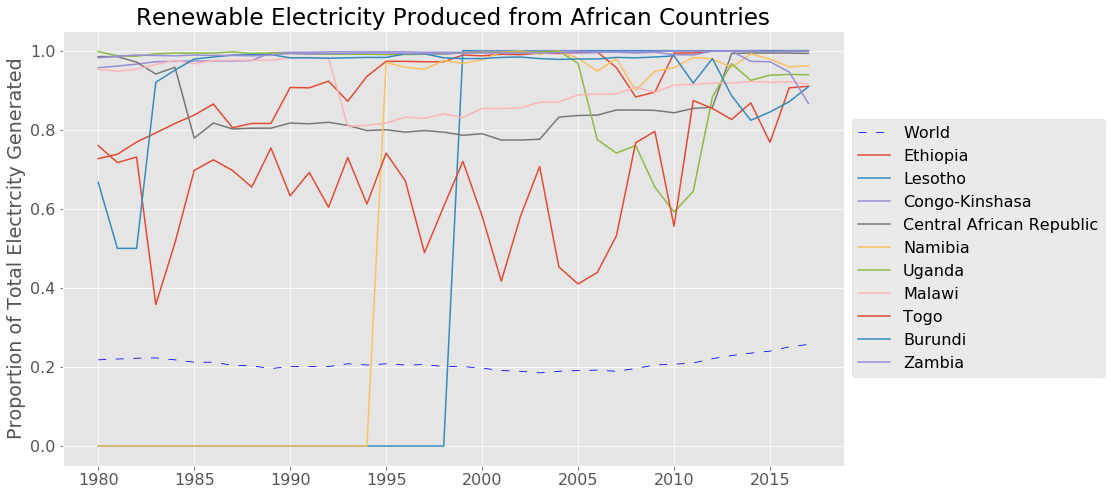

In [166]:
Africa_Analysis.plot_data(maxlines = 10, include_world=True)
plt.show()

In [167]:
MidEast_Analysis.fig.savefig('images/MidE.png',  bbox_inches='tight')

In [168]:
get_improved_countries(allcountries, improvement_perc=.27)['Improvement']   

Denmark           0.740
Luxembourg        0.635
Bhutan            0.625
Belize            0.521
Ecuador           0.439
Guatemala         0.406
United Kingdom    0.309
Germany           0.308
Uruguay           0.295
Guinea            0.280
Ethiopia          0.273
Name: Improvement, dtype: float64

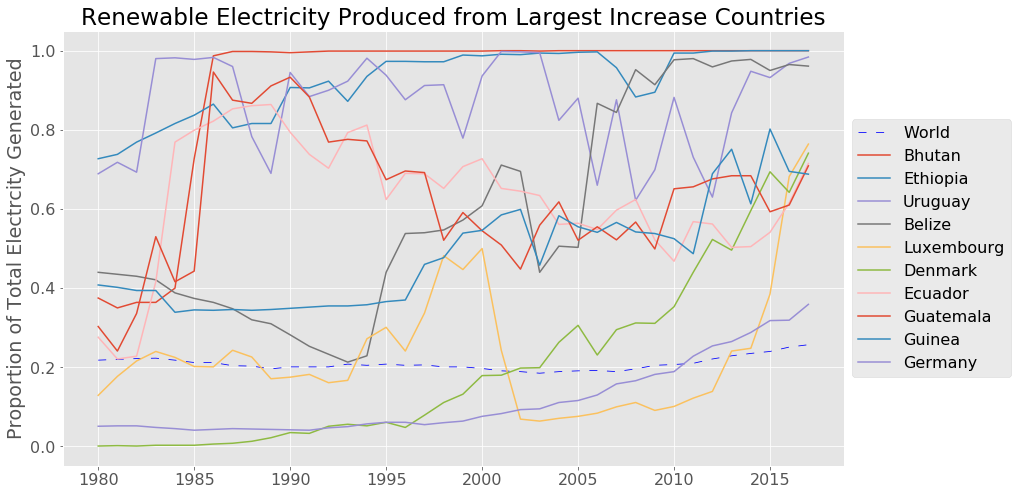

In [16]:
Improved_Analysis.plot_data(include_world = True)
plt.show()

In [17]:
Improved_Analysis.fig.savefig('images/MostImp.png',  bbox_inches='tight')

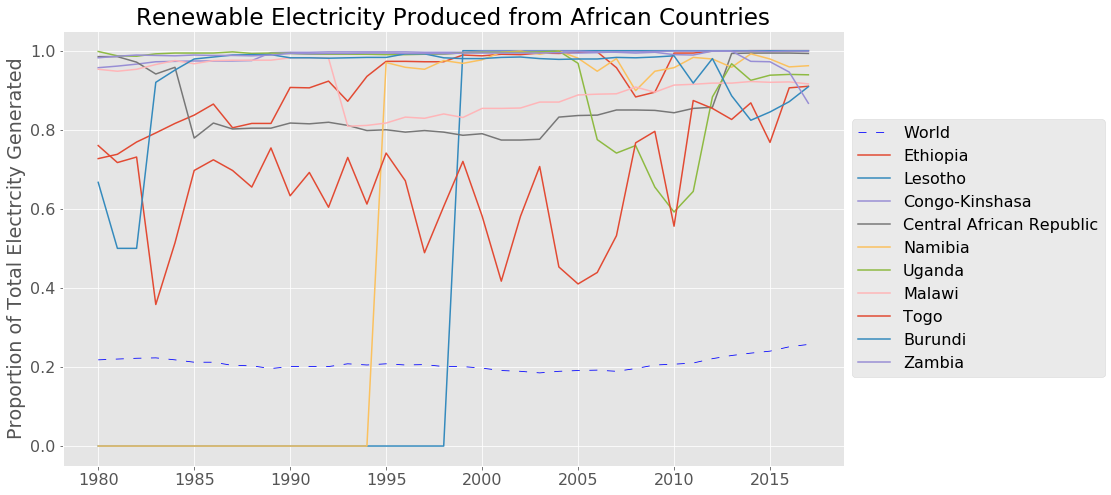

In [18]:
Africa_Analysis.plot_data(include_world = True)
plt.show()

In [19]:
Africa_Analysis.fig.savefig('images/Africa.png',  bbox_inches='tight')

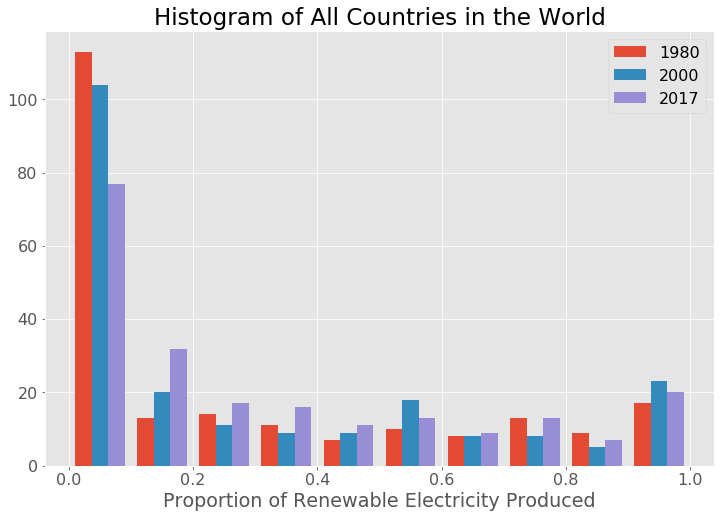

In [17]:
AllCountries_hist.make_hist()
plt.show()

In [18]:
AllCountries_hist.fig.savefig('images/Hist.png',  bbox_inches='tight')

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Text(0.5, 1.0, 'Top 10 Countries with Highest Renewable Electricity Proportions 2017')

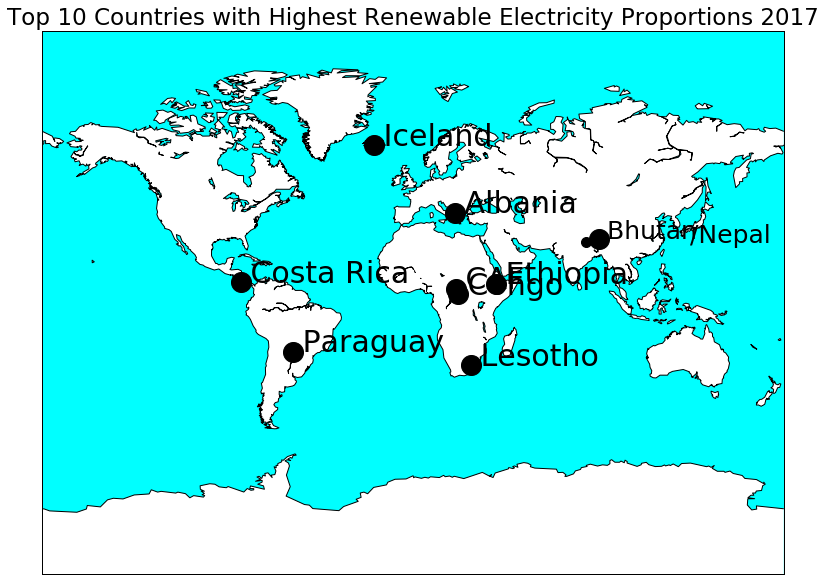

In [119]:
mapPlot = plt.figure(figsize = (20, 10))
map = Basemap(projection ='mill')

map.plot(0, 0)
map.drawmapboundary(fill_color = 'aqua')
map.fillcontinents(color='white',lake_color='aqua')
map.drawcoastlines()

x, y = map(20.168331, 41.15)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Albania', fontsize=30)

x, y = map(28.233608, -29.609988)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Lesotho', fontsize=30)

x, y = map(90.43, 30)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Bhutan', fontsize=25)

x, y = map(-19.02, 64.96)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Iceland', fontsize=30)

x, y = map(-58.44, -23.44)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Paraguay', fontsize=30)

x, y = map(84.12, 28.39)
plt.plot(x, y, 'ok', markersize=10)
plt.text(x, y,'             /Nepal', fontsize=25)

x, y = map(40.49, 9.145)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Ethiopia', fontsize=30)

x, y = map(21.76, 4.04)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Congo', fontsize=30)

x, y = map(-83.75, 9.75)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' Costa Rica', fontsize=30)

x, y = map(20.94, 6.61)
plt.plot(x, y, 'ok', markersize=20)
plt.text(x, y, ' CAF', fontsize=30)

plt.title('Top 10 Countries with Highest Renewable Electricity Proportions 2017')

In [120]:
mapPlot.savefig('images/Map.png')

In [25]:
highest_prop_countries

['Albania',
 'Lesotho',
 'Bhutan',
 'Iceland',
 'Paraguay',
 'Nepal',
 'Ethiopia',
 'Congo-Kinshasa',
 'Costa Rica',
 'Central African Republic',
 'Uruguay',
 'Norway',
 'Namibia',
 'Belize',
 'Tajikistan',
 'Uganda',
 'Kyrgyzstan',
 'Malawi',
 'Togo',
 'Burundi']